In [1]:
%matplotlib inline
import numpy as np
from astropy import units as u
from astropy import constants

import matplotlib.pyplot as plt
from astropy.stats import LombScargle

In [2]:
plt.rcParams['figure.dpi'] = 200

Ok, let's load up the data first and plot it to see what we're up against

In [3]:
t, y, yerr = np.loadtxt('data/lc.kepler.data', usecols=(0,1,2)).T

Text(0, 0.5, 'Flux')

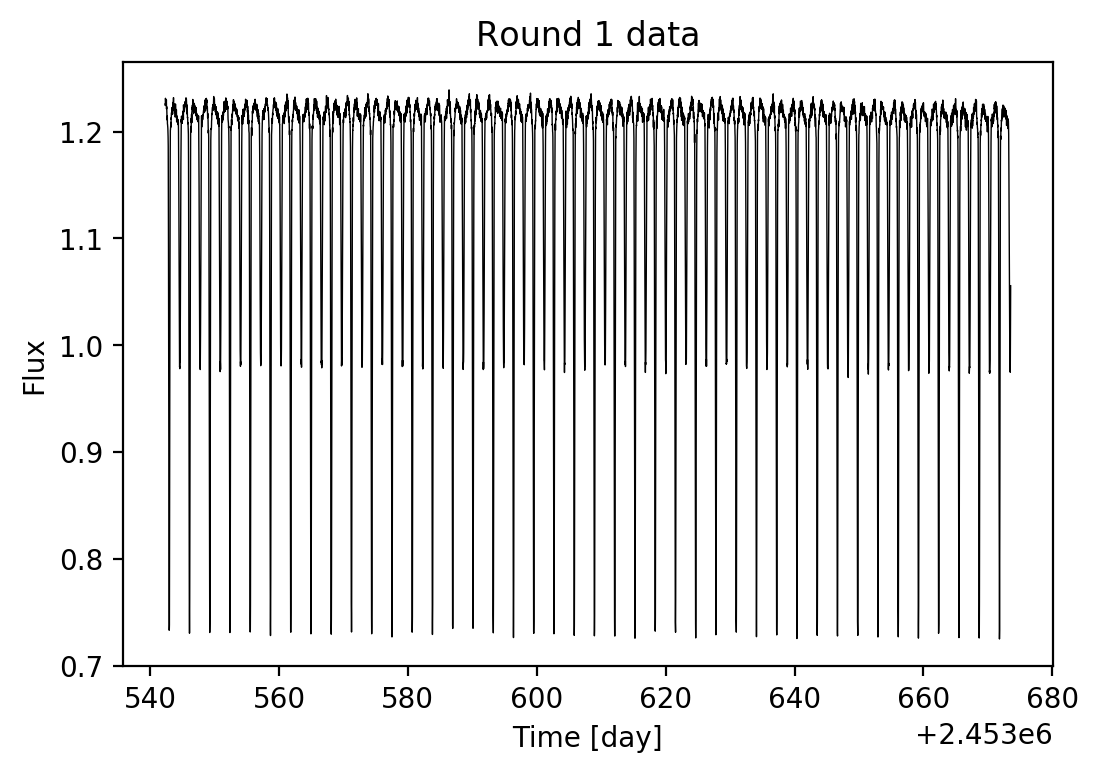

In [4]:
plt.plot(t, y, linewidth=0.5, c='black')
plt.title('Round 1 data')
plt.xlabel('Time [day]')
plt.ylabel('Flux')

This part here is incredibly overkill. I'm using a boxleastsquares algorithm to identify the orbital period of the system. This could easily be done by inspecting the amplitude spectrum or something. The bonus is that we get the depth ratios

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(t), dtype=bool)
period_grid = np.exp(np.linspace(np.log(2), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []
durations = []
stats = []
# Compute the periodogram for each star by iteratively masking out
# eclipses from the higher signal to noise star.
for i in range(2):
    bls = BoxLeastSquares(t[~m], y[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    durations.append(bls_power.duration[index])
    
    stats.append(bls.compute_stats(periods[i], durations[i], t0s[i]))

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(t, periods[-1], 0.5, t0s[-1])

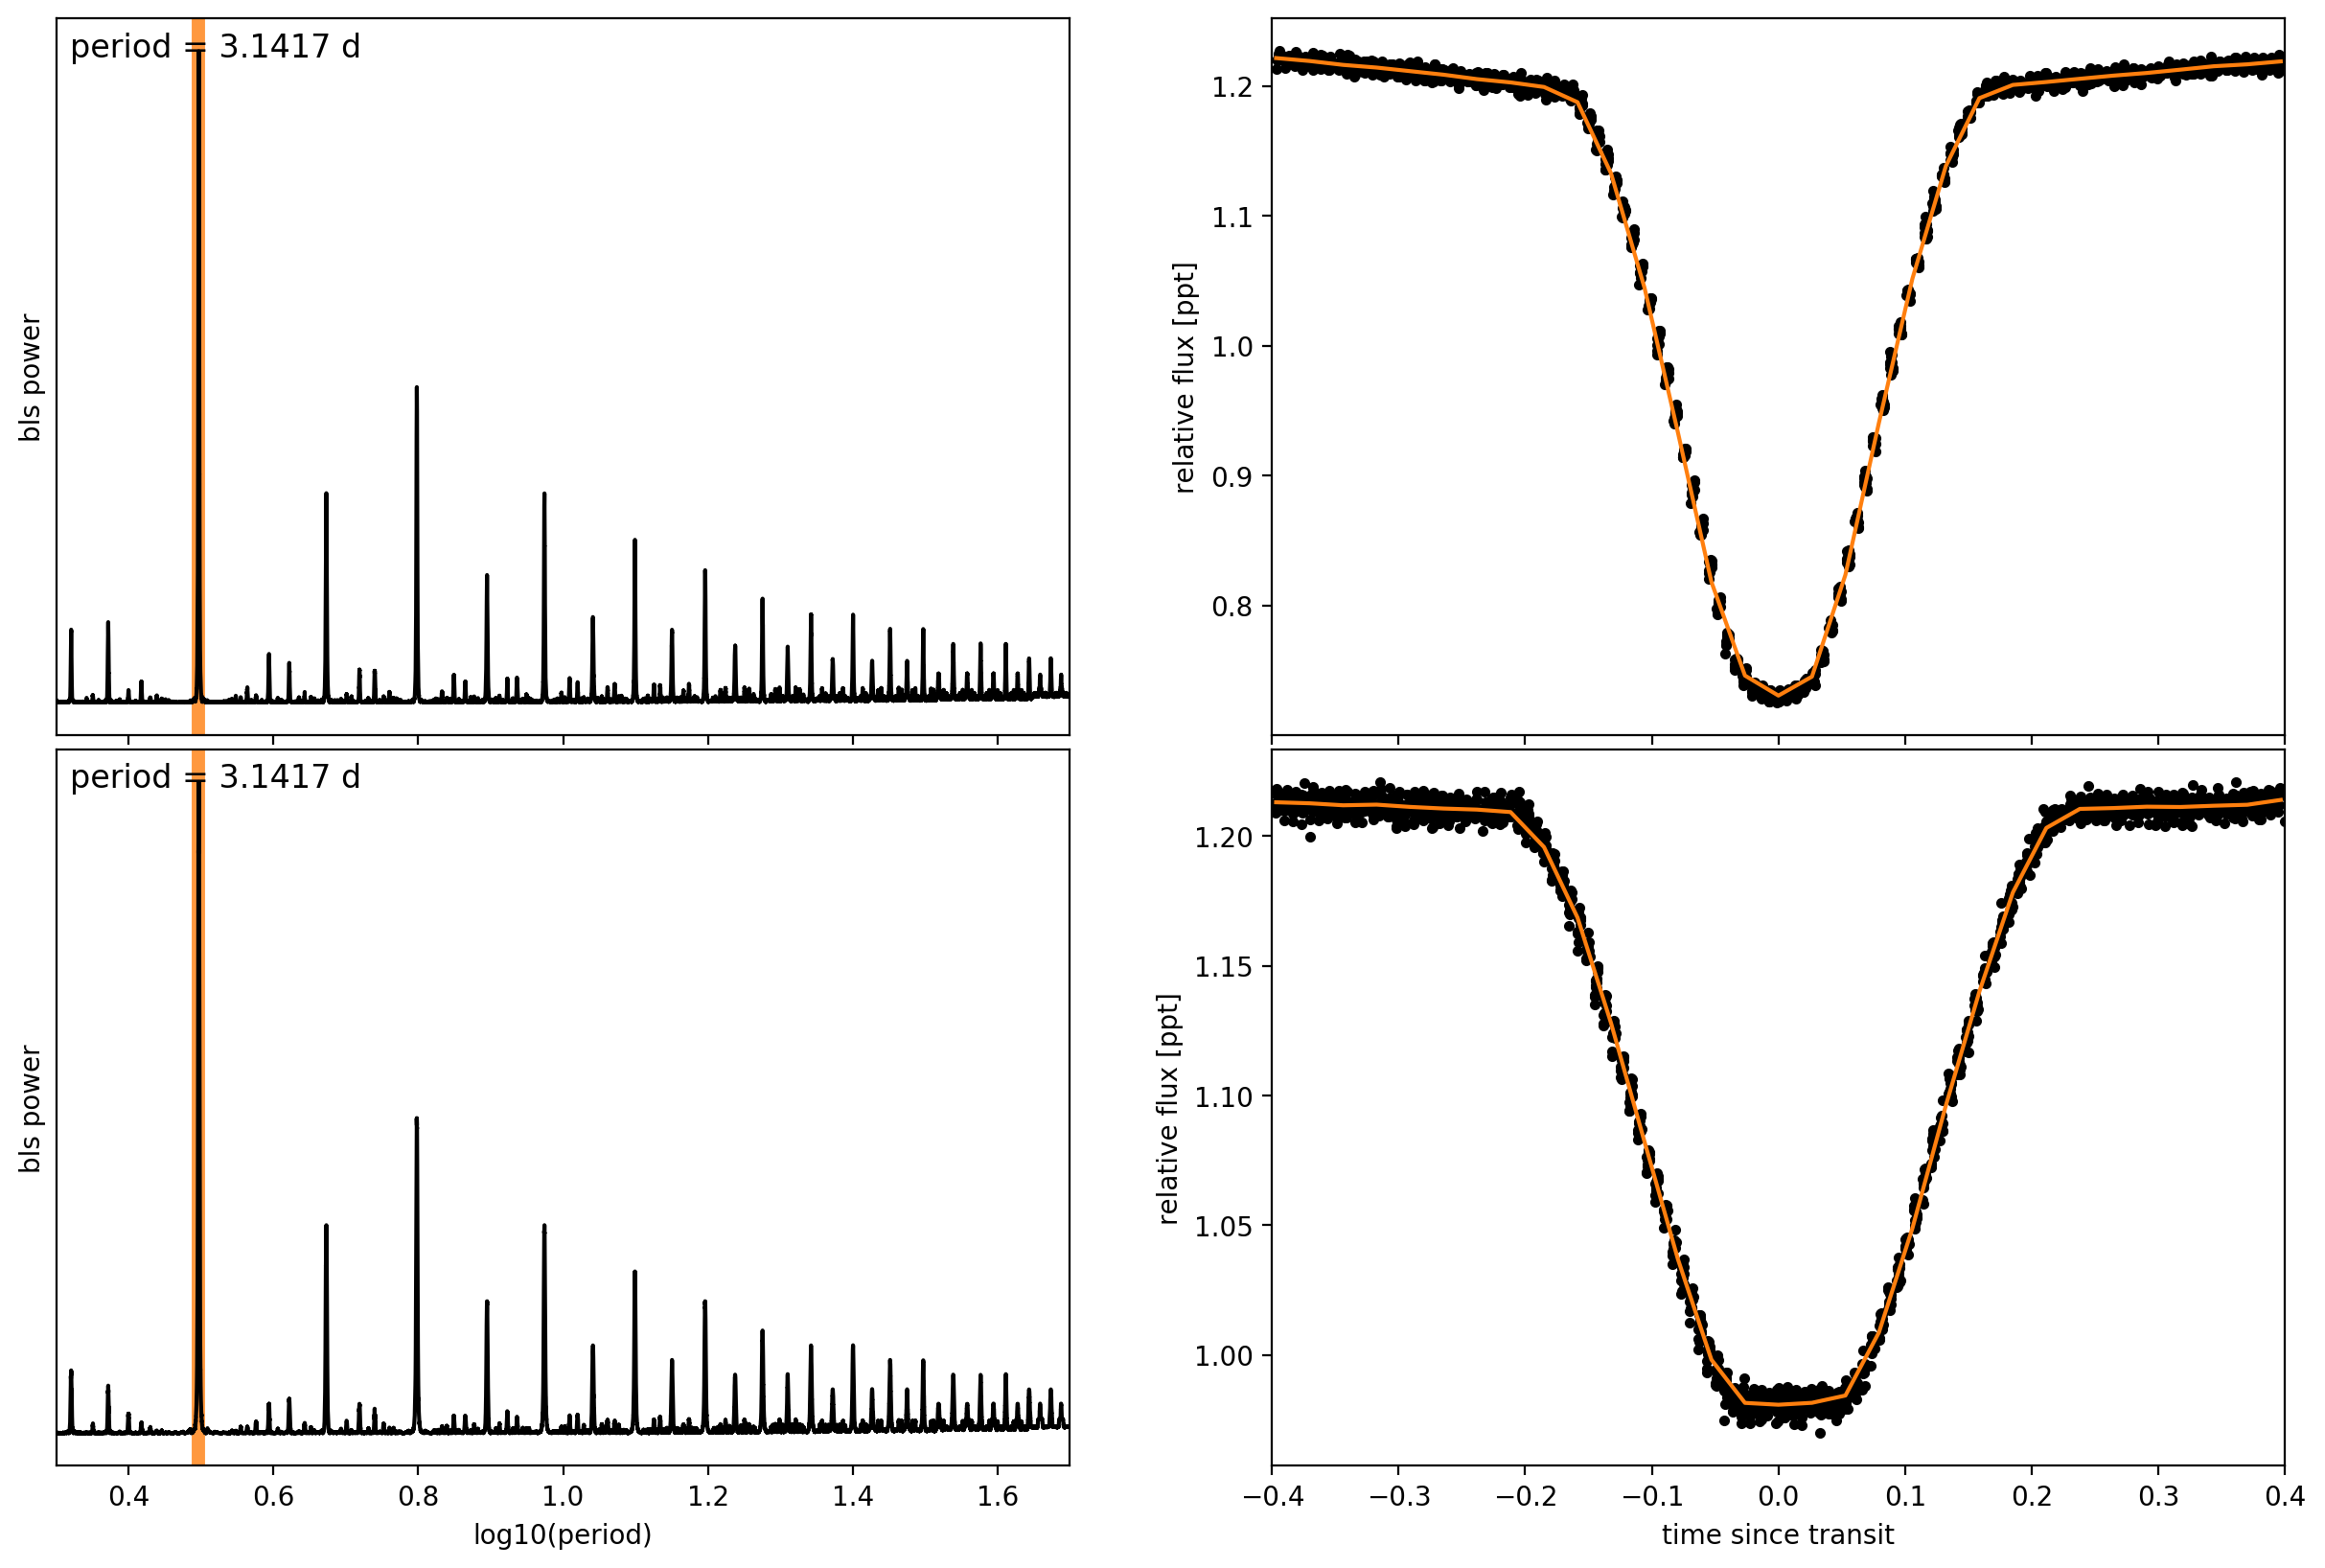

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")

    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (t - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m], ".k")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")

fig.subplots_adjust(hspace=0.02)

We get a good initial estimate of the orbital period

In [7]:
period = np.median(periods)
period

3.1417013711824193

And the ror

In [8]:
ror = depths[1]/depths[0]
ror

0.5145189890355694

### Steps:
1. T0
2. T0 + r_t, x, k
3. T0 + r_t, x, k + ecosw
4. T0 + r_t, x, k + ecosw + J_s, esinw
5. T0 + r_t, x, k + ecosw + J_s, esinw + A_p, A_s, P

Let's setup some convenience functions.. `init_bundle` generates a simple model with the proper constraints for flipping. `model` is a useful function which takes an arbitrary number of Phoebe parameters and their twigs and responds with the calculated model flux. `ln_like` is our log likelihood function, and `sort_flux` is a helper function to sort folded times

In [9]:
import phoebe

def init_bundle():
    """
    This is a convenience function to make a simple bundle for fitting, with all the constraints flipped around
    """
    bundle = phoebe.default_binary()
    
    # Speedups
    phoebe.interactive_constraints_off()
    bundle.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
    bundle.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)
    bundle.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)
    
    # Add some fitting constraints
    bundle.add_constraint('requivratio')
    bundle.add_constraint('requivsum')
    bundle.add_constraint('teffratio')

    # And flip them
    bundle.flip_constraint('requivratio', solve_for='requiv@primary')
    bundle.flip_constraint('requivsum', solve_for='requiv@secondary')
    bundle.flip_constraint('teffratio', solve_for='teff@secondary@component')
    bundle.flip_constraint('esinw', solve_for='ecc')
    bundle.flip_constraint('ecosw', solve_for='per0')
    
    return bundle

def model(params, twigs, bundle, time):
    """
    Our model, takes in an array of parameter values, their corresponding twigs (sue me)
    in Phoebe, and a bundle object, and returns the flux at those values.
    """
    # Iterate over pairs of parameter and twig values, assigning them to the bundle
    for param, twig in zip(params, twigs):
        bundle[twig] = param
    
    bundle.run_compute()
    
    # Since i'm fitting a transit initially, I don't want no interpolation
    flux = bundle['fluxes@latest@model'].get_value()#.interp_value(times=time)
    return flux

def lnlike(params, twigs, bundle, flux, time, flux_err):
    try:
        model_flux = model(params, twigs, bundle, time)
        return -0.5 * np.sum((flux - model_flux)**2 / flux_err**2)
    except:
        # Here we catch overflows in the model. This is a cheap prior that should be implemented properly
        return -np.inf
    
def sort_flux(time, period, flux):
    fold_time = time % period / period
    sort = np.argsort(fold_time)
    return fold_time[sort], flux[sort]

Here's where the fun starts ..! We want to start off by fitting a single eclipse, and then extending that to the full light curve. Minimisers are sensitive to fitting in a huge parameter space at once, so we start off simple then extend it. 

I do a rough estimate of t0 by taking the minimum flux value and slice out some data around that point. This is our primary eclipse which we'll initially work with. These kinds of things should be taken out of the box least squares results

Text(0, 0.5, 'Flux')

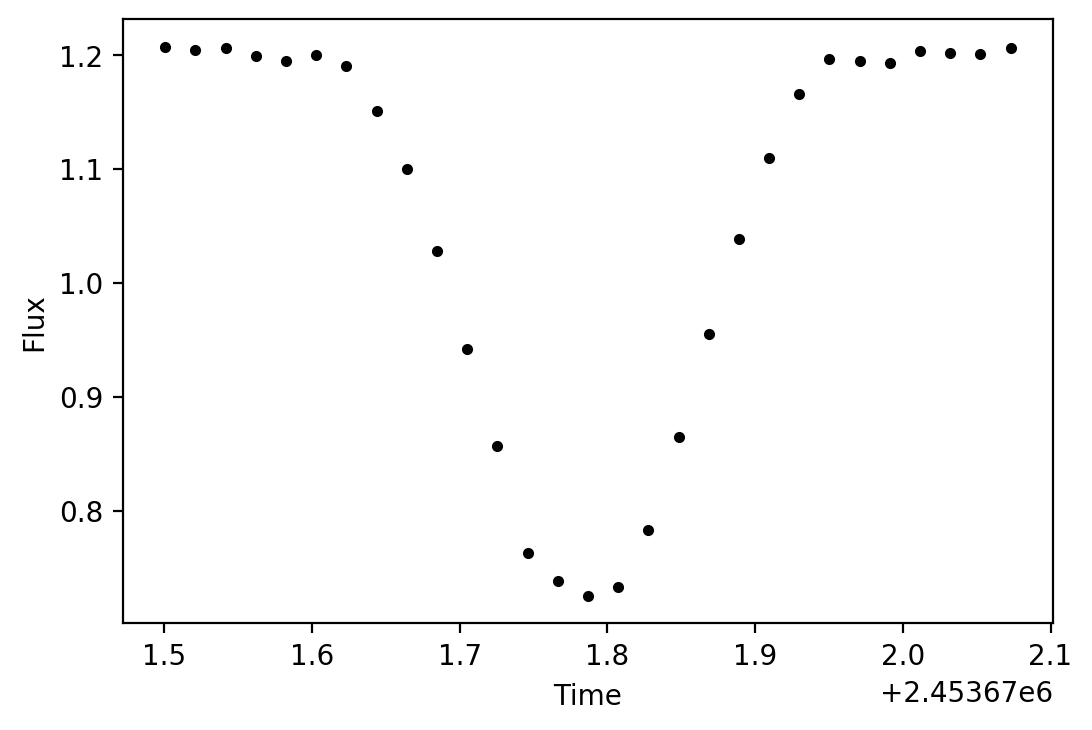

In [10]:
t0_guess = t[np.argmin(y)]

spacing = 0.3

y_transit = y[(t > t0_guess-spacing) & (t < t0_guess+spacing)]
t_transit = t[(t > t0_guess-spacing) & (t < t0_guess+spacing)]
yerr_transit = yerr[(t > t0_guess-spacing) & (t < t0_guess+spacing)]

plt.plot(t_transit, y_transit, '.k')
plt.xlabel('Time')
plt.ylabel('Flux')

In [11]:
# Our humble phoebe bundle
b = init_bundle()

# Let's add our primary transit, and set things to be dataset scaled
b.add_dataset('lc', times=t_transit, fluxes=y_transit, passband='Kepler:mean', dataset='primary_transit')
b['pblum_mode'] = 'dataset-scaled'

In [12]:
# We want to fit in steps, so we start with something simple: period and T0
params = [np.pi, t0_guess]
# Their corresponding twigs
twigs = ['period@orbit', 't0']

In [13]:
from scipy.optimize import minimize

# Since we're using an optimizer, we want to minimise the negative log-likelihood. Here's a lambda function
# which aliases `lnlike`.
nll = lambda *args: -lnlike(*args)

It's also worthwhile knowing how slow it is..

In [14]:
%timeit model(params, twigs, b, t_transit)

551 ms ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# Let's fit!
soln = minimize(nll, params, args=(twigs, b, y_transit, t_transit, yerr_transit), 
               method='Nelder-Mead', tol=100
               )

In [16]:
soln

 final_simplex: (array([[3.1415926e+00, 2.4535520e+06],
       [3.1415926e+00, 2.4536119e+06],
       [3.1415926e+00, 2.4534921e+06]]), array([1789.17197975, 1789.24102614, 1790.78660883]))
           fun: 1789.1719797488736
       message: 'Optimization terminated successfully.'
          nfev: 80
           nit: 30
        status: 0
       success: True
             x: array([3.1415926e+00, 2.4535520e+06])

In [17]:
# Here I assign the optimised values back to the bundle
for param, twig in zip(soln['x'], twigs):
    b[twig] = param

Let's see what our model looks like after fitting just t0 and period

Text(0, 0.5, 'Flux (norm)')

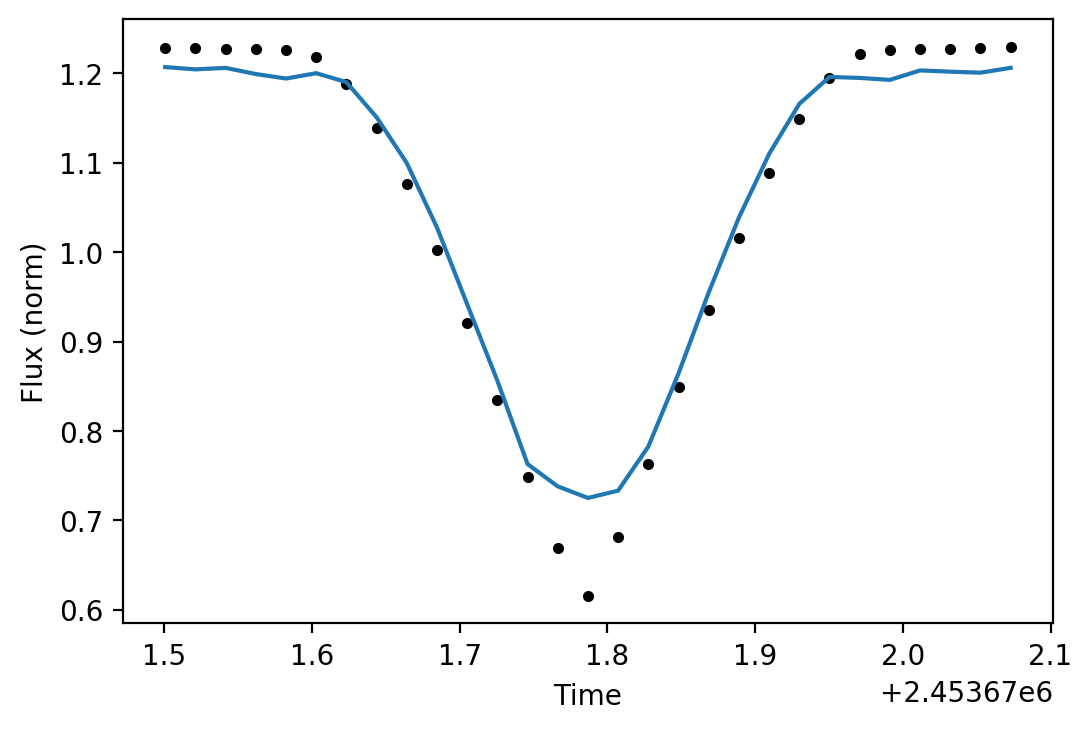

In [18]:
flux = model(soln['x'], twigs, b, t_transit)
plt.plot(t_transit, flux, '.k')
plt.plot(t_transit, y_transit)

plt.xlabel('Time')
plt.ylabel('Flux (norm)')

Now we'll try something a bit more difficult, the inclination, and radii ratio/sum

In [19]:
initial = np.array([87, 0.6,2.])
twigs = ['incl@orbit', 'requivratio', 'requivsum']
soln = minimize(nll, initial, args=(twigs, b, y_transit, t_transit, yerr_transit), 
                method='Nelder-Mead', tol=100
               )

In [20]:
soln

 final_simplex: (array([[89.29997714,  0.73274806,  1.8712239 ],
       [90.6380668 ,  0.72603776,  1.79812973],
       [89.81806318,  0.71213954,  1.8049624 ],
       [90.93479081,  0.70814472,  1.81503201]]), array([ 65.11243786,  88.32818976,  96.64193384, 124.41316995]))
           fun: 65.11243786030388
       message: 'Optimization terminated successfully.'
          nfev: 30
           nit: 15
        status: 0
       success: True
             x: array([89.29997714,  0.73274806,  1.8712239 ])

In [21]:
for param, twig in zip(soln['x'], twigs):
    b[twig] = param

Text(0, 0.5, 'Flux (norm)')

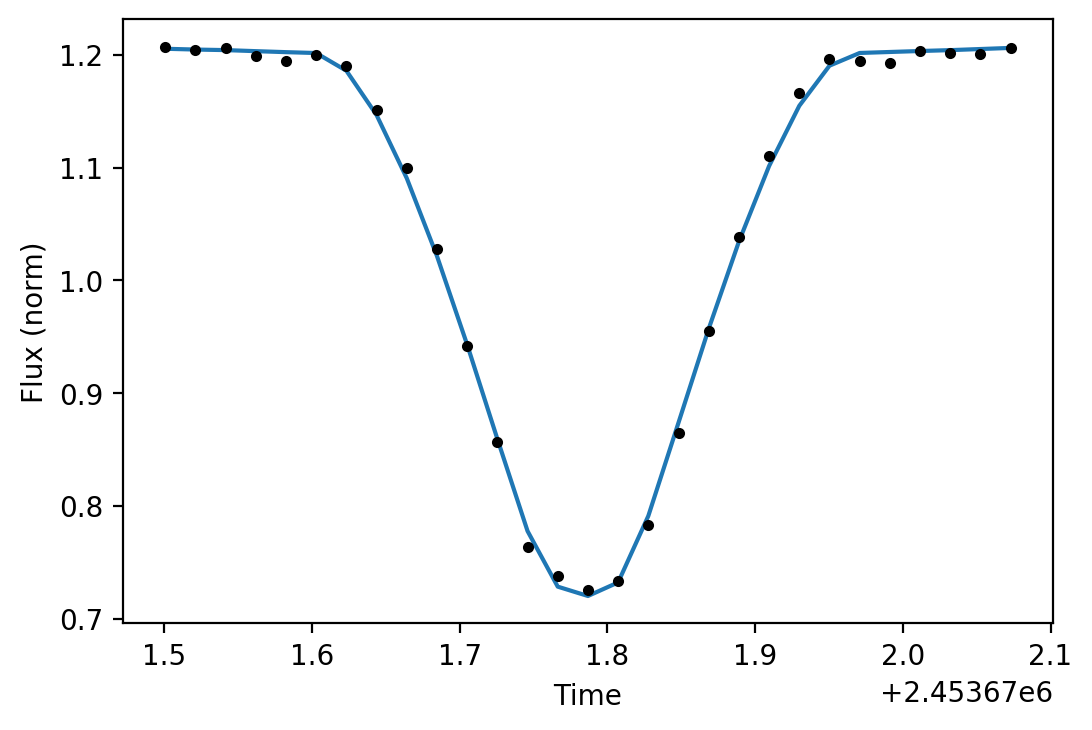

In [23]:
flux = model(soln['x'], twigs, b, t_transit)
plt.plot(t_transit, flux)
plt.plot(t_transit, y_transit,'.k')

plt.xlabel('Time')
plt.ylabel('Flux (norm)')


dat shit cray

We're done with the primary transit. Now we want to fit the whole light curve! We'll add the full lc as another dataset, though I'm sure Kyle would have some cool way of calculating at specific times for the transit

In [24]:
b.add_dataset('lc', times=t, fluxes=y, 
              passband='Kepler:mean', dataset='full_lc')

<ParameterSet: 19 parameters | contexts: constraint, dataset, compute>

Flip the constraint to solve for phase instead of time

In [25]:
b['pblum_mode@full_lc@lc@dataset'] = 'dataset-scaled'
b.flip_constraint('compute_phases@full_lc', 'compute_times@full_lc@lc@dataset')

<ConstraintParameter: {compute_times@full_lc@dataset} = {compute_phases@full_lc@dataset} * {period@binary@component} (solar units) => [] d>

In [26]:
phases = np.linspace(0,1,101)
b.set_value('compute_phases@full_lc@lc', phases)

Disable the transit dataset

In [27]:
b['primary_transit@compute@enabled'].set_value(False)

We have to remake the model here to interpolate values

In [28]:
def model(params, twigs, bundle, time):
    for param, twig in zip(params, twigs):
        bundle[twig] = param
    print(params)    
    bundle.run_compute()
    
    flux = bundle['fluxes@latest@model'].interp_value(times=time)
    return flux

We'll now fit ecosw, esinw, incl, and radii. If we automate this, we should extract ecos and esinw straight from the light curve

[8.92999771e+01 7.32748057e-01 1.87122390e+00 3.00000000e-02
 1.00000000e-01 8.00000000e-01]


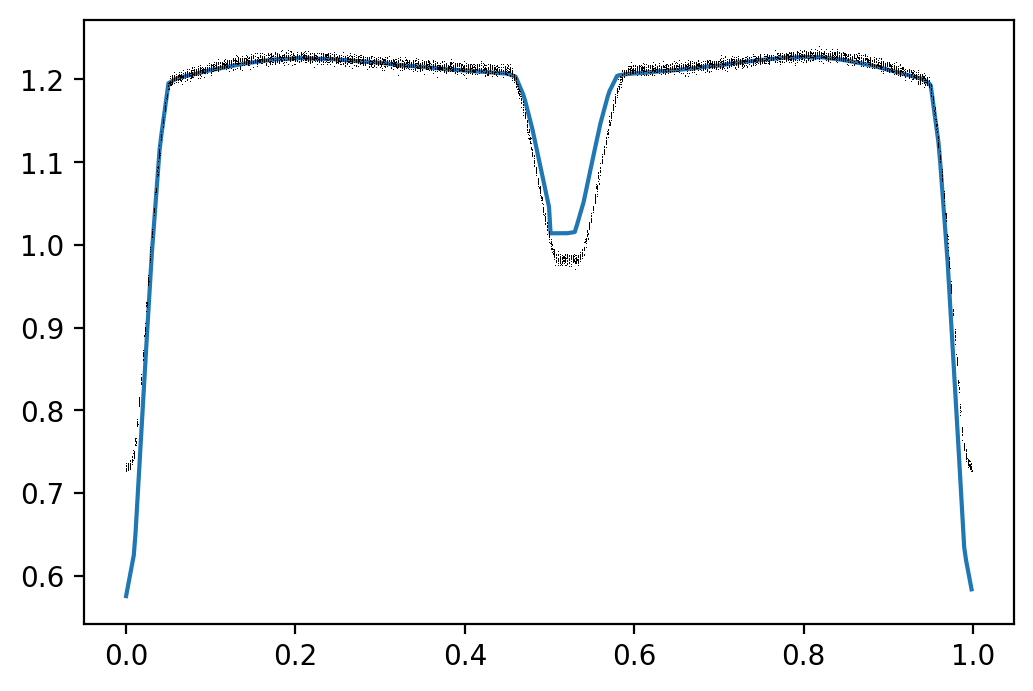

In [31]:
initial = np.array([b['incl@orbit'].value,  b['requivratio'].value,  b['requivsum'].value, 
                    0.03, 0.1, 0.8])
twigs = ['incl@orbit', 'requivratio', 'requivsum', 'ecosw', 
                     'esinw', 'teffratio']

flux = model(initial, twigs, b, t)

plt.plot(*sort_flux(t, b['period@orbit'].value, flux))
plt.plot(*sort_flux(t, b['period@orbit'].value, y), ',k')

In [32]:
soln = minimize(nll, initial, args=(twigs, b, y, t, yerr), 
                method='Nelder-Mead', 
                options={'maxiter': 200},
                tol=1000
               )

[8.92999771e+01 7.32748057e-01 1.87122390e+00 3.00000000e-02
 1.00000000e-01 8.00000000e-01]
[9.37649760e+01 7.32748057e-01 1.87122390e+00 3.00000000e-02
 1.00000000e-01 8.00000000e-01]
[8.92999771e+01 7.69385460e-01 1.87122390e+00 3.00000000e-02
 1.00000000e-01 8.00000000e-01]
[8.92999771e+01 7.32748057e-01 1.96478509e+00 3.00000000e-02
 1.00000000e-01 8.00000000e-01]
[8.92999771e+01 7.32748057e-01 1.87122390e+00 3.15000000e-02
 1.00000000e-01 8.00000000e-01]
[8.92999771e+01 7.32748057e-01 1.87122390e+00 3.00000000e-02
 1.05000000e-01 8.00000000e-01]
[8.92999771e+01 7.32748057e-01 1.87122390e+00 3.00000000e-02
 1.00000000e-01 8.40000000e-01]
[9.07883101e+01 6.96110654e-01 1.90241096e+00 3.05000000e-02
 1.01666667e-01 8.13333333e-01]
[9.12844211e+01 7.20535589e-01 1.78805839e+00 3.06666667e-02
 1.02222222e-01 8.17777778e-01]
[9.19459024e+01 7.16464767e-01 1.85389775e+00 3.08888889e-02
 1.02962963e-01 8.23703704e-01]
[9.32688650e+01 7.08323121e-01 1.84523468e+00 3.13333333e-02
 1.044444

[9.06140988e+01 6.33885058e-01 1.92148265e+00 3.27788386e-02
 1.04084185e-01 8.75786869e-01]


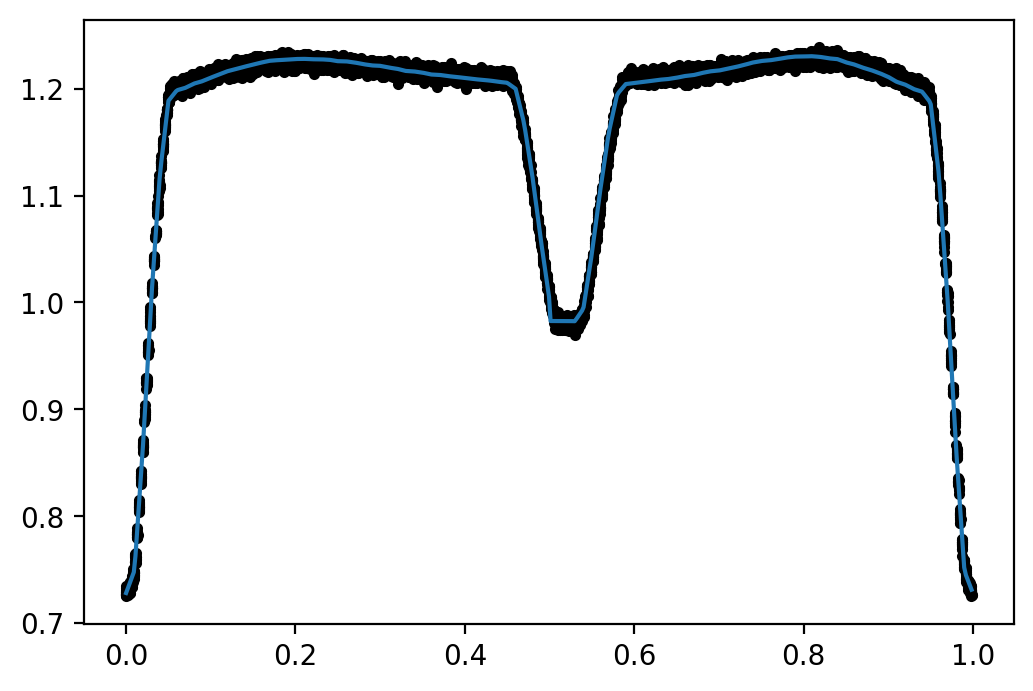

In [34]:
flux = model(soln['x'], twigs, b, t)

plt.plot(*sort_flux(t, b['period@orbit'].value, y), '.k')
plt.plot(*sort_flux(t, b['period@orbit'].value, flux))

## Let's do this all in one go

In [ ]:
def model(params, twigs, bundle, time=None):
    """
    Our model, takes in an array of parameter values, their corresponding twigs (sue me)
    in Phoebe, and a bundle object, and returns the flux at those values.
    """
    # Iterate over pairs of parameter and twig values, assigning them to the bundle
    for param, twig in zip(params, twigs):
        bundle[twig] = param
    
    bundle.run_compute()
    
    if time is None:
        flux = bundle['fluxes@latest@model'].get_value()
    else:
        flux = bundle['fluxes@latest@model'].interp_value(times=time)
        
    return flux

def get_default_value(twigs, bundle):
    return [bundle[twig].value for twig in twigs]

def assign_value(params, twigs, bundle):
    for param, twig in zip(params, twigs):
        bundle[twig] = param

# Our humble phoebe bundle
b = init_bundle()

# Let's add our primary transit, and set things to be dataset scaled
b.add_dataset('lc', times=t_transit, fluxes=y_transit, passband='Kepler:mean', dataset='primary_transit')
b['pblum_mode'] = 'dataset-scaled'

In [ ]:
optimization_path_twigs = [
    ['period@orbit', 't0'],
    ['incl@orbit', 'requivratio', 'requivsum'],
    ['incl@orbit', 'requivratio', 'requivsum', 'ecosw', 'esinw', 'teffratio']
]

In [ ]:
for optimization_twig in optimization_path_twigs:
    pass


# THIS IS WHERE I'M UP TO. THE REST IS RANDOM CODE CHUNK NOTES

In [ ]:
from scipy.optimize import dual_annealing

In [ ]:
soln

In [23]:
def bin_data(t,y, binsize=13, method='mean'):
    
    available_methods = ['mean', 'median']
    if method not in available_methods:
        raise ValueError("method must be one of: {}".format(available_methods))
    methodf = np.__dict__['nan' + method]

    n_bins = y.size // binsize
    indexes = np.array_split(np.arange(len(t)), n_bins)
    binned_lc_time = np.array([methodf(t[a]) for a in indexes])
    binned_lc_flux = np.array([methodf(y[a]) for a in indexes])

    return binned_lc_time,binned_lc_flux

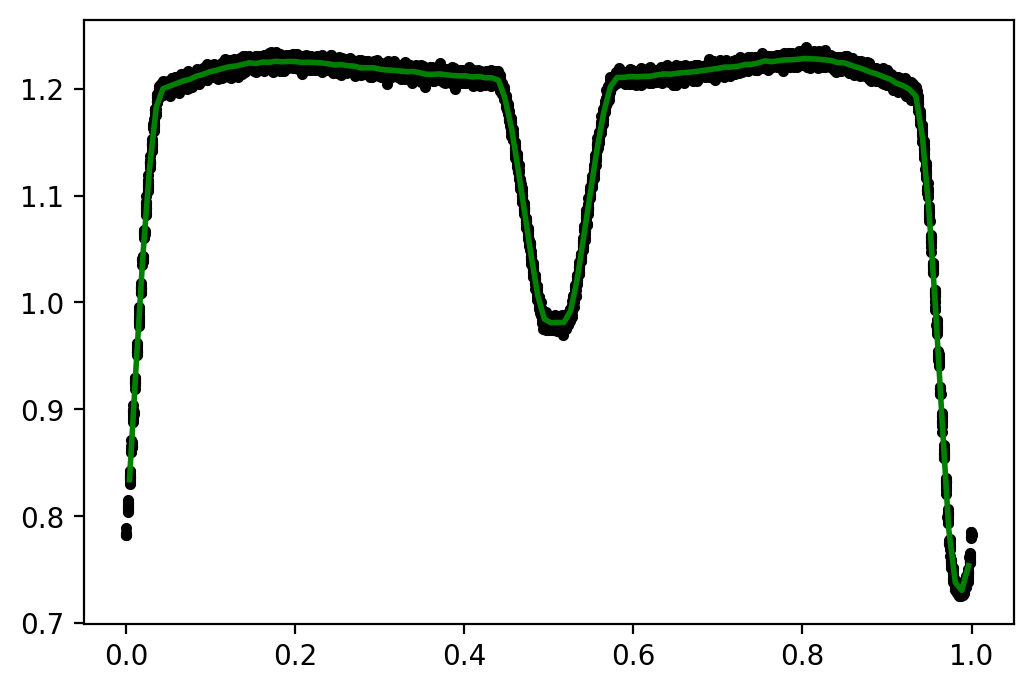

In [24]:
period = np.pi#(1/fmax)*2

folded_time = t % period / period
sort = np.argsort(folded_time)

folded_time = folded_time[sort]
folded_flux = y[sort]

plt.plot(folded_time, folded_flux, '.k')


binned_time, binned_flux = bin_data(folded_time, folded_flux, binsize=50, method='mean')
plt.plot(binned_time, binned_flux, c='green', linewidth=2.)

In [33]:
# Our humble phoebe bundle
#b = init_bundle()

# Let's add our primary transit, and set things to be dataset scaled
b.add_dataset('lc', times=binned_time, fluxes=binned_flux, passband='Kepler:mean', dataset='full_lc')
b['pblum_mode@full_lc'] = 'dataset-scaled'

In [26]:
b['primary_transit@compute@enabled'].set_value(False)

In [32]:
b.remove_dataset('full_lc')

In [34]:
b['pblum_mode@full_lc'] = 'dataset-scaled'
b.flip_constraint('compute_phases@full_lc', 'compute_times@full_lc')
b.set_value('compute_phases@full_lc', binned_time)

In [37]:
def model(params, twigs, bundle, time):
    for param, twig in zip(params, twigs):
        bundle[twig] = param
    print(params)    
    bundle.run_compute()
    
    flux = bundle['fluxes@latest@model'].get_value()#.interp_value(times=time)
    return flux

In [49]:
twigs

['t0', 'period@orbit', 'requivratio', 'requivsum']

[2.4535520e+06 3.1415926e+00 7.3286565e-01 1.9647851e+00]


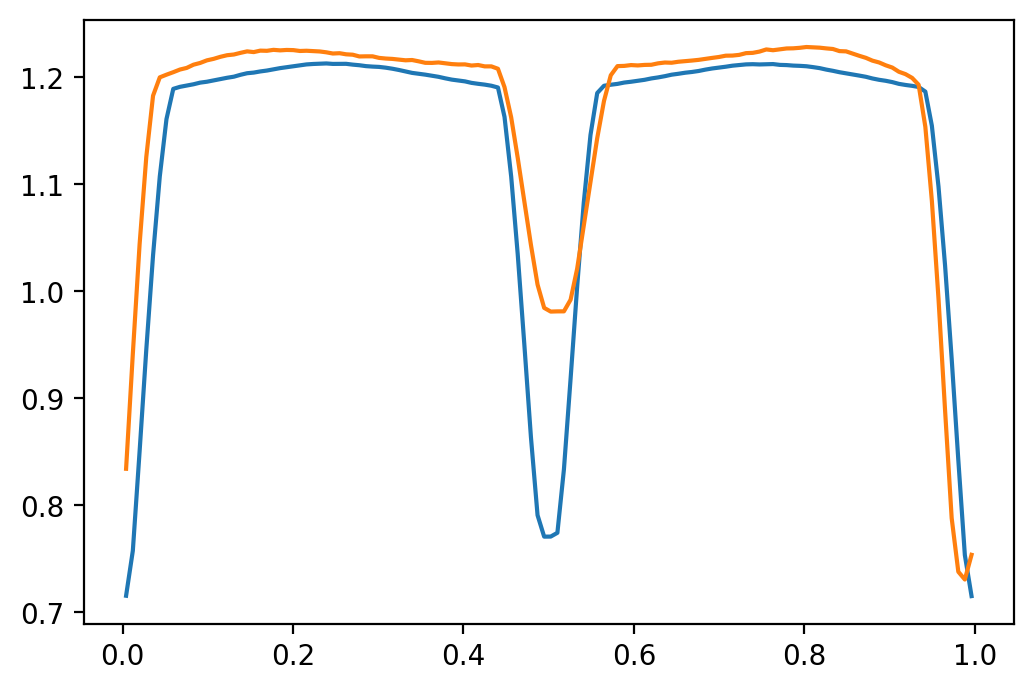

In [50]:
initial = np.array([2.4535520e+06, 3.1415926e+00, 7.3286565e-01, 1.9647851e+00])
twigs = ['t0', 'period@orbit', 'requivratio', 'requivsum']

flux = model(initial, twigs, b, binned_time)

plt.plot(binned_time, flux)
plt.plot(binned_time, binned_flux)

In [46]:
soln = minimize(nll, initial, args=(twigs, b, binned_flux, binned_time, np.ones_like(binned_flux)*0.03), 
                #method='Nelder-Mead', 
                #tol=100
               )

[2.4535520e+06 3.1415926e+00 7.3286565e-01 1.9647851e+00]
[2.4535520e+06 3.1415926e+00 7.3286565e-01 1.9647851e+00]
[2.45355200e+06 3.14159260e+00 7.32865650e-01 1.96478511e+00]
[2.4535520e+06 3.1415926e+00 7.3286565e-01 1.9647851e+00]


/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


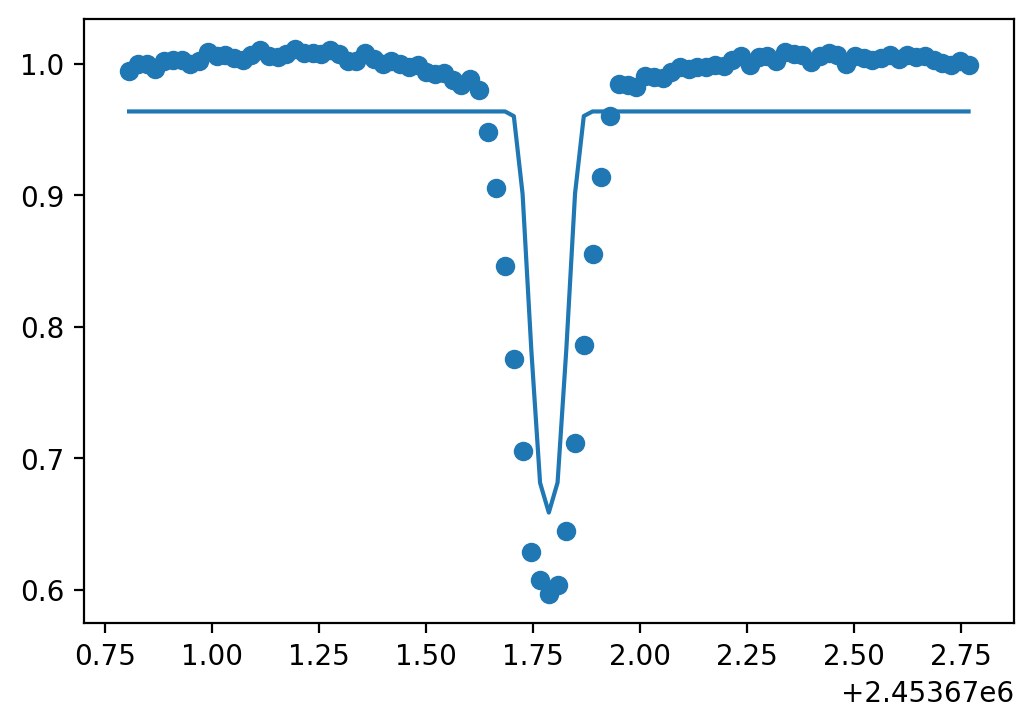

In [37]:
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt

with pm.Model() as model:
    # Fix the period to the known value
    period = np.pi
    
    # The time of conjunction
    tc = pm.Normal("tc", mu=t0_guess, sd=1.0, shape=1, testval=t0_guess)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(y_transit)), sd=10)
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.3, max_radius=0.9,
        testval_r=0.5,
        testval_b=0.2
    )
    
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=1e-3, upper=0.99, testval=0.13794166194446114)
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=np.mean(y))
    # Quadratic limb darkening, sue me Andrej
    u_star = xo.distributions.QuadLimbDark("u_star")
    
    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(
        period=period, 
        t0=tc,
        ecc=eccen,
        omega=omega,
        b=b
    )
    
    incl = pm.Deterministic('inclination', orbit.incl)
            
    # Compute the model light curve
    light_curves = xo.StarryLightCurve(u_star).get_light_curve(
        orbit=orbit, r=r, t=t_transit, texp=29.4/1440.)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    
    # I can't account for the ellipsoidal variations in the LC,
    # so let's instead model it out as noise using a gaussian process
    """logw0_guess = np.log(2*np.pi/10)
    logw0 = pm.Normal("logw0", mu=logw0_guess, sd=100)
    logpower = pm.Normal("logpower", mu=np.log(np.var(y)) + 4*logw0_guess, sd=100)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))    
    gp = xo.gp.GP(kernel, t_transit, tt.exp(2*logs_lc) + tt.zeros(len(t_transit)), J=2)
    
    pm.Potential("obs", gp.log_likelihood(y_transit - light_curve))
    pm.Deterministic("gp_pred", gp.predict())"""
    
    pm.Normal('obs', mu=light_curve, observed=y_transit)
    
    plt.plot(t_transit, xo.eval_in_model(light_curve))
    plt.scatter(t_transit, y_transit)

In [38]:
with model:
    map_params = xo.optimize(start=None, vars=[tc])
    map_params = xo.optimize(start=map_params, vars=[r, b, tc])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params)

optimizing logp for variables: ['tc']


/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -105.11660963559316 -> -105.11649664840319
optimizing logp for variables: ['tc', 'rb_radiusimpact__']


/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -105.11649664840319 -> -104.83022399389147
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']


/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -104.83022399389147 -> -83.54231731038183
optimizing logp for variables: ['u_star_quadlimbdark__', 'mean', 'eccen_interval__', 'omega_angle__', 'rb_radiusimpact__', 'logs_lc', 'tc']


/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -83.54231731038183 -> -83.49671211407198


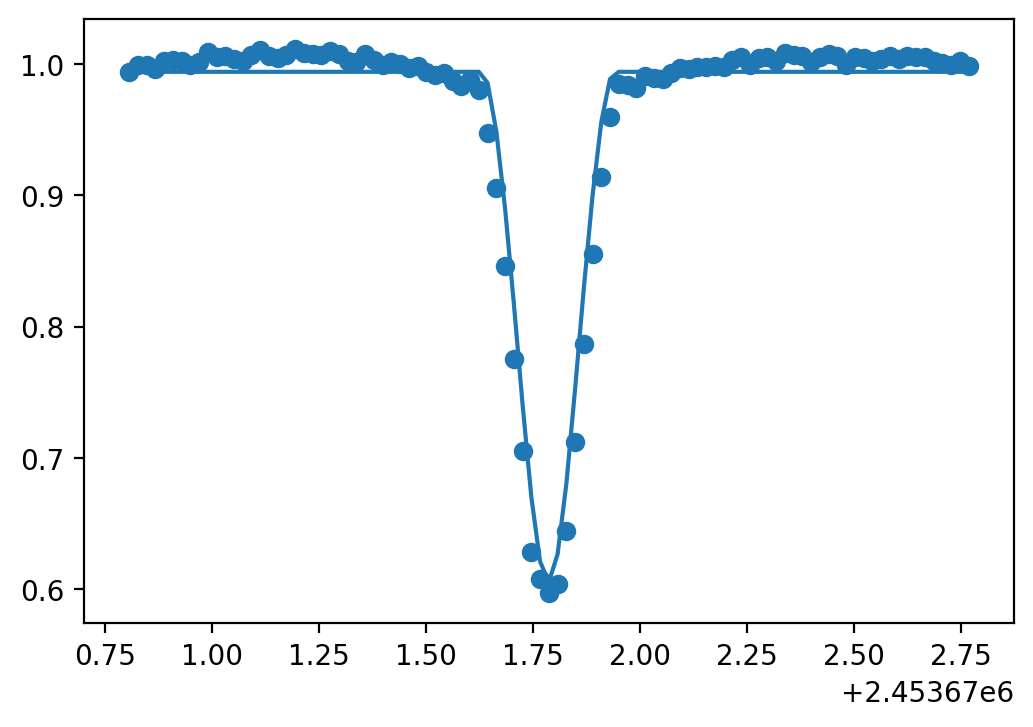

In [39]:
with model:    
    plt.plot(t_transit, xo.eval_in_model(light_curve, map_params))
    plt.scatter(t_transit, y_transit)

In [40]:
map_params

{'tc': array([2453671.78523803]),
 'logs_lc': array(-2.31313421),
 'rb_radiusimpact__': array([[-0.08320575],
        [ 0.07924977]]),
 'omega_angle__': array([-4.47213573e+00,  1.10416853e-04]),
 'eccen_interval__': array(0.0787426),
 'mean': array(0.99413199),
 'u_star_quadlimbdark__': array([-0.00054215, -0.00052551]),
 'rb': array([[0.61188125],
        [0.46673689]]),
 'r': array([0.61188125]),
 'b': array([0.46673689]),
 'omega': array(-1.57077164),
 'eccen': array(0.51495905),
 'u_star': array([7.06825163e-01, 1.85771606e-04]),
 'inclination': array([1.60493274])}

In [41]:
np.degrees(1.60493274)

91.95587240436707

In [219]:
rs / (1 + k)

0.23282908381115042

### Steps:
1. T0
2. T0 + r_t, x, k
3. T0 + r_t, x, k + ecosw
4. T0 + r_t, x, k + ecosw + J_s, esinw
5. T0 + r_t, x, k + ecosw + J_s, esinw + A_p, A_s, P

### Steps:
1. T0
2. T0 + r_t, x, k
3. T0 + r_t, x, k + ecosw
4. T0 + r_t, x, k + ecosw + J_s, esinw
5. T0 + r_t, x, k + ecosw + J_s, esinw + A_p, A_s, P

Parameters:
J_s - Surface brightness ratio (secondary / primary)
r_s = fractional sum of radii (r1 + r2 ) / a
k = ratio of radii (secondary / primary)
x = fractional impact parameter
A_p = primary bolometric reflection
A_s = secondary bolometric reflection
T0 = time of primary eclipse
P = period

In [248]:
params = batman.TransitParams()
params.t0 = t0_guess                       #time of inferior conjunction
params.per = np.pi                     #orbital period
params.rp = 0.6394                    #planet radius (in units of stellar radii)
params.a = 1                     #semi-major axis (in units of stellar radii)
params.inc = 87.3                     #orbital inclination (in degrees)
params.ecc = 0.143                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
params.fp=np.mean(y_transit) - 1
params.limb_dark = "quadratic"       #limb darkening model
params.t_secondary = np.pi + np.pi/2

In [249]:

m = batman.TransitModel(params, t, transittype='primary')    #initializes model
m2 = batman.TransitModel(params, t, transittype='secondary')    #initializes model
flux = m.light_curve(params) + m2.light_curve(params) - 1.        #calculates light curve

In [1]:
exposure=29.4/1440.
ss_batman=11

params = batman.TransitParams()
params.t0 = t0_guess
params.per = np.pi
params.rp = 0.643
params.a = 1.
params.inc = 87.
params.ecc = 0.134
params.w = 87.3
params.limb_dark = "nonlinear"          #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]       #limb darkening coefficients

m = batman.TransitModel(params, t, supersample_factor = ss_batman, exp_time = exposure)      #initializes model
flux_primary = m.light_curve(params)
"""
params.fp = 0.2
params.t_secondary = np.pi + np.pi/2
m = batman.TransitModel(params, t, supersample_factor = ss_batman, exp_time = exposure, transittype="secondary")       
flux_secondary = m.light_curve(params)
"""
plt.plot(t, flux_primary + 0.2,
         #+ flux_secondary - 1., 
         alpha=0.5, c='red')
plt.plot(t, y, alpha=0.2, c='blue')

plt.xlabel("Time (days)") 
plt.ylabel("Relative flux")
plt.show()

NameError: name 'batman' is not defined

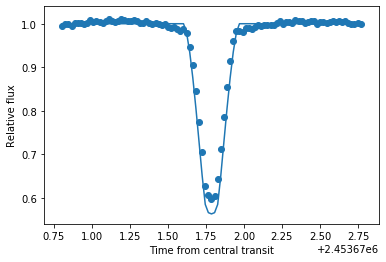

In [230]:
period = np.pi#(1/fmax)*2

folded_time = t % period / period
sort = np.argsort(folded_time)

folded_time = folded_time[sort]
folded_flux = y[sort]

plt.plot(folded_time, folded_flux, '.k')


binned_time, binned_flux = bin_data(folded_time, folded_flux, binsize=10, method='mean')

Compiling `render`... Done.


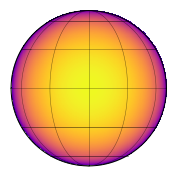

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import exoplanet as xo
import starry
import theano
import theano.tensor as tt
np.random.seed(12)

A = starry.Map(udeg=2)
A[1] = 0.40
A[2] = 0.25
A.r = 1.0
A.L = 1.0
A.show()

Compiling `render`... Done.


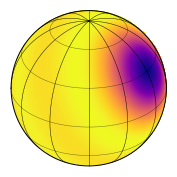

In [6]:
B = starry.Map(ydeg=5)
B.inc = 60
B.add_spot(amp=-0.2, lat=30, lon=60)
B_true_map = B[1:, :].eval()
B.P = 0.11
B.t0 = 0.0
B.r = 0.4
B.L = 0.1
B.show()

In [7]:
t = np.linspace(-0.5, 0.5, 10000)
orbit_A = xo.orbits.KeplerianOrbit(period=0.3, a=10.0, t0=0.0, incl=89*np.pi/180., r_star=B.r)
flux_A = A.flux(orbit=orbit_A, t=t).eval()
orbit_B = xo.orbits.KeplerianOrbit(period=0.3, a=10.0, t0=0.15, incl=89*np.pi/180., r_star=A.r)
flux_B = B.flux(orbit=orbit_B, t=t).eval()

# The observed flux is the sum
flux_true = flux_A + flux_B

# Add noise
sigma = 0.001
flux = flux_true + sigma * np.random.randn(len(t))

/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

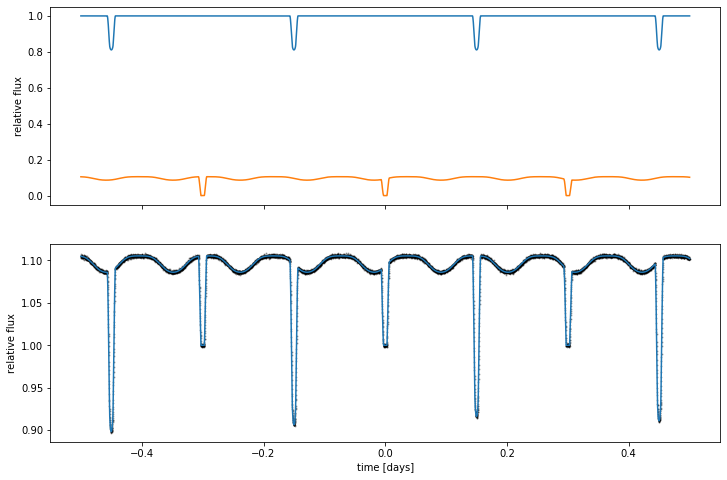

In [8]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 8))
ax[0].plot(t, flux_A)
ax[0].plot(t, flux_B)
ax[0].set_ylabel("relative flux")
ax[1].plot(t, flux, 'k.', alpha=0.3, ms=2)
ax[1].plot(t, flux_true)
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("relative flux");

In [9]:
with pm.Model() as model:
    # Everything we assume we know
    A = starry.Map(udeg=2)
    A[1] = 0.40
    A[2] = 0.25
    A.r = 1.0
    A.L = 1.0
    B = starry.Map(ydeg=5)
    B.inc = 60
    B.P = 0.11
    B.t0 = 0.0
    B.r = 0.4
    B.L = 0.1
    orbit_A = xo.orbits.KeplerianOrbit(period=0.3, a=10.0, t0=0.0, incl=89*np.pi/180., r_star=B.r)
    orbit_B = xo.orbits.KeplerianOrbit(period=0.3, a=10.0, t0=0.15, incl=89*np.pi/180., r_star=A.r)
    
    # The Ylm coefficients with a simple gaussian prior
    ncoeff = B.Ny - 1
    mu = np.zeros(ncoeff)
    cov = 1e-2 * np.eye(ncoeff)
    Ylm = pm.MvNormal("Ylm", mu, cov, shape=(ncoeff,))
    B[1:, :] = Ylm
    
    # Compute the flux
    flux_A = A.flux(orbit=orbit_A, t=t)
    flux_B = B.flux(orbit=orbit_B, t=t)
    flux_model = flux_A + flux_B
    
    # Track some values for plotting later
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = xo.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=sigma, observed=flux)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

In [10]:
with model:
    map_soln = xo.optimize()

/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: ['Ylm']


/Users/danielhey/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -224840.18726896378 -> 55004.71316970965


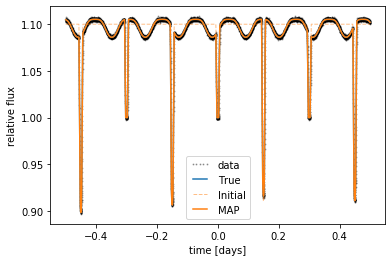

In [11]:
plt.plot(t, flux, 'k.', alpha=0.3, ms=2, label="data")
plt.plot(t, flux_true, "C0-", label="True")
plt.plot(t, flux_model_guess, "C1--", lw=1, alpha=0.5, label="Initial")
plt.plot(t, xo.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP")
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("time [days]")
plt.ylabel("relative flux");

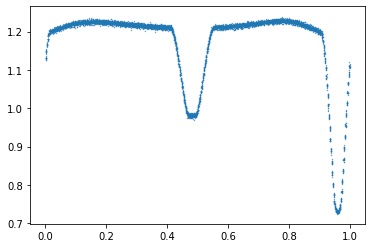

In [14]:

folded_time = t % period / period
sort = np.argsort(folded_time)

folded_time = folded_time[sort]
folded_flux = y[sort]

plt.scatter(folded_time, folded_flux, 0.1)

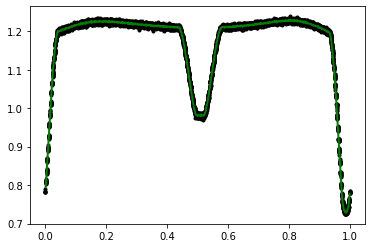

In [19]:
period = np.pi#(1/fmax)*2

folded_time = t % period / period
sort = np.argsort(folded_time)

folded_time = folded_time[sort]
folded_flux = y[sort]

plt.plot(folded_time, folded_flux, '.k')


binned_time, binned_flux = bin_data(folded_time, folded_flux, binsize=10, method='mean')
plt.plot(binned_time, binned_flux, c='green', linewidth=2.)

In [91]:
find_highest_peak(folded_flux, binned_time[p][1])

0.9869520332864683

In [92]:
binned_time[p][1]

0.9869520332864683

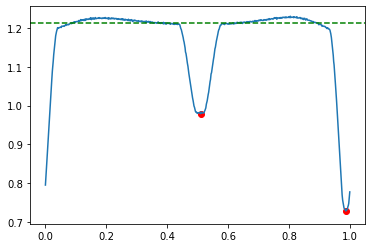

In [82]:
binned_time, binned_flux = bin(folded_time, folded_flux, binsize=10, method='mean')
plt.plot(binned_time, binned_flux)

from scipy.signal import find_peaks
p = find_peaks(-binned_flux, height=-1., distance=100)[0]
plt.scatter(binned_time[p], binned_flux[p], c='r')
plt.axhline(np.median(binned_flux), c='g', linestyle='--')

In [85]:
np.median(binned_flux)

1.2142710635494667

In [86]:
np.tan((binned_time[p][0]-binned_time[p][1]) * np.pi - np.pi/2)

0.07248929299826241

In [216]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(2), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

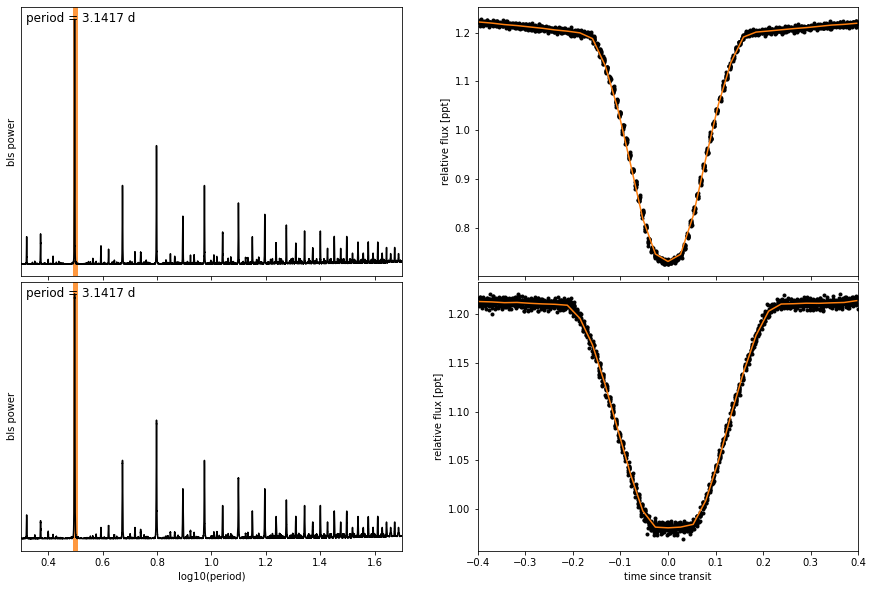

In [220]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")

    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m], ".k")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")

fig.subplots_adjust(hspace=0.02)

In [221]:
bls_results

[          depth: array([0.01794062, 0.01708397, 0.01607032, ..., 0.2149248 , 0.21576902,
        0.2149248 ])
       depth_err: array([0.0576065 , 0.05777961, 0.05743505, ..., 0.33356733, 0.33356733,
        0.33356733])
       depth_snr: array([0.31143404, 0.29567467, 0.27979985, ..., 0.6443221 , 0.64685298,
        0.6443221 ])
        duration: array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])
  log_likelihood: array([0.05101576, 0.04596826, 0.04119169, ..., 0.20786702, 0.20950322,
        0.20786702])
       objective: 'likelihood'
          period: array([ 2.        ,  2.00012876,  2.00025753, ..., 49.99356253,
        49.99678116, 50.        ])
           power: array([0.05101576, 0.04596826, 0.04119169, ..., 0.20786702, 0.20950322,
        0.20786702])
    transit_time: array([ 1.788     ,  1.85698785,  1.90115169, ..., 43.74451702,
        35.49918682, 27.813     ]),
           depth: array([0.00602101, 0.00440641, 0.00438587, ..., 0.11228879, 0.11311211,
        0.11303311])
       

In [210]:
a = bls.compute_stats(period, duration, transit_time)

In [214]:
a

{'transit_times': array([2453542.978     , 2453546.11968495, 2453549.26136989,
        2453552.40305484, 2453555.54473978, 2453558.68642473,
        2453561.82810967, 2453564.96979462, 2453568.11147957,
        2453571.25316451, 2453574.39484946, 2453577.5365344 ,
        2453580.67821935, 2453583.81990429, 2453586.96158924,
        2453590.10327419, 2453593.24495913, 2453596.38664408,
        2453599.52832902, 2453602.67001397, 2453605.81169891,
        2453608.95338386, 2453612.09506881, 2453615.23675375,
        2453618.3784387 , 2453621.52012364, 2453624.66180859,
        2453627.80349353, 2453630.94517848, 2453634.08686343,
        2453637.22854837, 2453640.37023332, 2453643.51191826,
        2453646.65360321, 2453649.79528815, 2453652.9369731 ,
        2453656.07865805, 2453659.22034299, 2453662.36202794,
        2453665.50371288, 2453668.64539783, 2453671.78708277]),
 'per_transit_count': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5

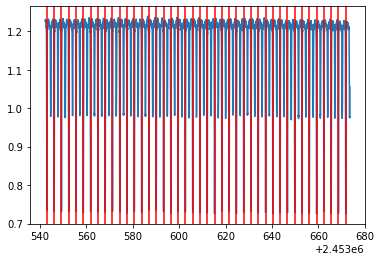

In [213]:
plt.plot(t,y)
for i in a['transit_times']:
    plt.axvline(i, c='r')

Text(0.5, 0, 'time since eclipse')

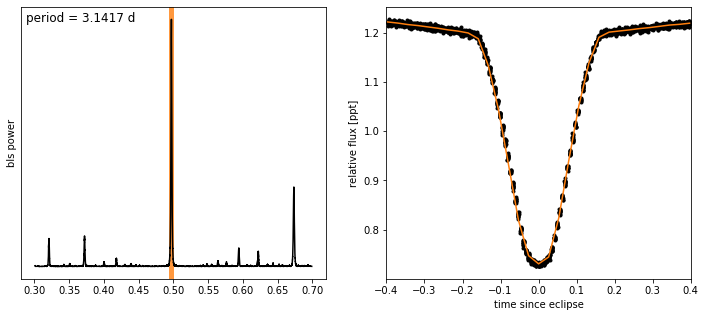

In [187]:
fig, axes = plt.subplots(1, 2, figsize=[12,5])
x, y = t, y
# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(results.period), results.power, "k")
ax.annotate("period = {0:.4f} d".format(period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])

# Plot the folded transit
ax = axes[1]
p = period
x_fold = (x - t0 + 0.5*p) % p - 0.5*p
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], y[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.4, 0.4)
ax.set_ylabel("relative flux [ppt]")
ax.set_xlabel("time since eclipse")


In [197]:
lc = LightCurve

NameError: name 'LightCurve' is not defined

In [184]:
from transitleastsquares import transitleastsquares
model = transitleastsquares(t, y/np.median(y))
results = model.power()

/Users/danielhey/anaconda3/envs/phoebe_workshop/lib/python3.7/site-packages/transitleastsquares/validate.py:31: UserWarning: Warning: The mean flux should be normalized to 1, but it was found to be 0.9635880545488017
  warnings.warn(text)
  0%|          | 0/14624 periods | 00:00<?

Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 39 durations
Searching 6417 data points, 14624 periods from 0.602 to 65.586 days
Using all 4 CPU threads


100%|██████████| 14624/14624 periods | 01:32<00:00


In [200]:
model.compute_stats?

Object `model.compute_stats` not found.


In [198]:
transitleastsquares?

Init signature: transitleastsquares(t, y, dy=None)
Docstring:      Compute the transit least squares of limb-darkened transit models
File:           ~/anaconda3/envs/phoebe_workshop/lib/python3.7/site-packages/transitleastsquares/main.py
Type:           type
Subclasses:     


In [185]:
results

{'SDE': 33.4958370742225,
 'SDE_raw': 33.4958370742225,
 'chi2_min': 1888.737142680433,
 'chi2red_min': 0.2945169410073964,
 'period': 1.570893296813733,
 'period_uncertainty': 0.0021053803769208734,
 'T0': 2453542.998727774,
 'duration': 0.18738793592367853,
 'depth': 0.7195239237991877,
 'depth_mean': (0.761909898218855, 0.003598457409554979),
 'depth_mean_even': (0.6888920975276339, 0.004542842315998601),
 'depth_mean_odd': (0.834927698910076, 0.0018605233920429935),
 'transit_depths': array([0.68878316, 0.83890066, 0.67970644, 0.83782252, 0.68492063,
        0.83328153, 0.68968502, 0.8390388 , 0.68084871, 0.83813282,
        0.6844876 , 0.83511006, 0.69135779, 0.84082221, 0.68043306,
        0.83711558, 0.68439712, 0.83451787, 0.69241734, 0.84069981,
        0.68093338, 0.8395635 , 0.68492394, 0.83308427, 0.69166285,
        0.84048438, 0.680813  , 0.83883172, 0.68512842, 0.83448442,
        0.69253345, 0.83933532, 0.68202249, 0.83898537, 0.68362778,
        0.83452778, 0.69128101,

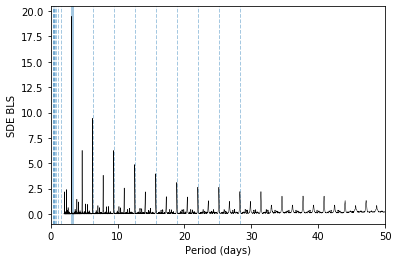

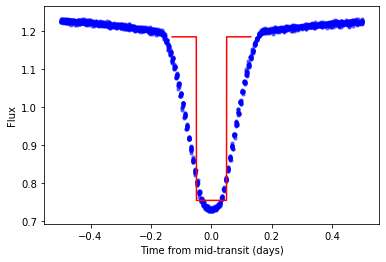

In [228]:
from astropy.stats import BoxLeastSquares
import numpy

durations = np.exp(np.linspace(np.log(2), np.log(50), 50000))

model_bls = BoxLeastSquares(t, y)
results_bls = model_bls.power(durations, 0.1, oversample=20)
period = results_bls.period[numpy.argmax(results_bls.power)]

plt.figure()
ax = plt.gca()
ax.axvline(period, alpha=0.4, lw=3)
for n in range(2, 10):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE BLS')
plt.xlabel('Period (days)')
plt.plot(results_bls.period, results_bls.power, color='black', lw=0.5)
plt.xlim(0, max(results_bls.period));

index = numpy.argmax(results_bls.power)
period = results_bls.period[index]
t0 = results_bls.transit_time[index]
duration = results_bls.duration[index]

plt.figure()
ax = plt.gca()
x = (t - t0 + 0.5*period) % period - 0.5*period
m = numpy.abs(x) < 0.5
plt.scatter(
    x[m],
    y[m],
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)
x = numpy.linspace(-0.13, 0.13, 1000)
f = model_bls.model(x + t0, period, duration, t0)
ax.plot(x, f, color='red')
ax.set_xlabel("Time from mid-transit (days)")
ax.set_ylabel("Flux");

In [230]:
results_bls

          depth: array([0.01794062, 0.01708397, 0.01607032, ..., 0.2149248 , 0.21576902,
       0.2149248 ])
      depth_err: array([0.0576065 , 0.05777961, 0.05743505, ..., 0.33356733, 0.33356733,
       0.33356733])
      depth_snr: array([0.31143404, 0.29567467, 0.27979985, ..., 0.6443221 , 0.64685298,
       0.6443221 ])
       duration: array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])
 log_likelihood: array([0.05101576, 0.04596826, 0.04119169, ..., 0.20786702, 0.20950322,
       0.20786702])
      objective: 'likelihood'
         period: array([ 2.        ,  2.00012876,  2.00025753, ..., 49.99356253,
       49.99678116, 50.        ])
          power: array([0.05101576, 0.04596826, 0.04119169, ..., 0.20786702, 0.20950322,
       0.20786702])
   transit_time: array([ 1.788     ,  1.85698785,  1.90115169, ..., 43.74451702,
       35.49918682, 27.813     ])

In [94]:
print('Period', format(results.period, '.5f'), 'd')
print(len(results.transit_times), 'transit times in time series:', \
        ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Transit depth', format(results.depth, '.5f'))
print('Best duration (days)', format(results.duration, '.5f'))
print('Signal detection efficiency (SDE):', results.SDE)

Period nan d


TypeError: object of type 'float' has no len()